Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *  # frowned upon in Python

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [2]:
df_voles = pd.read_csv('http://bit.ly/2IgDF0E')

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [3]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

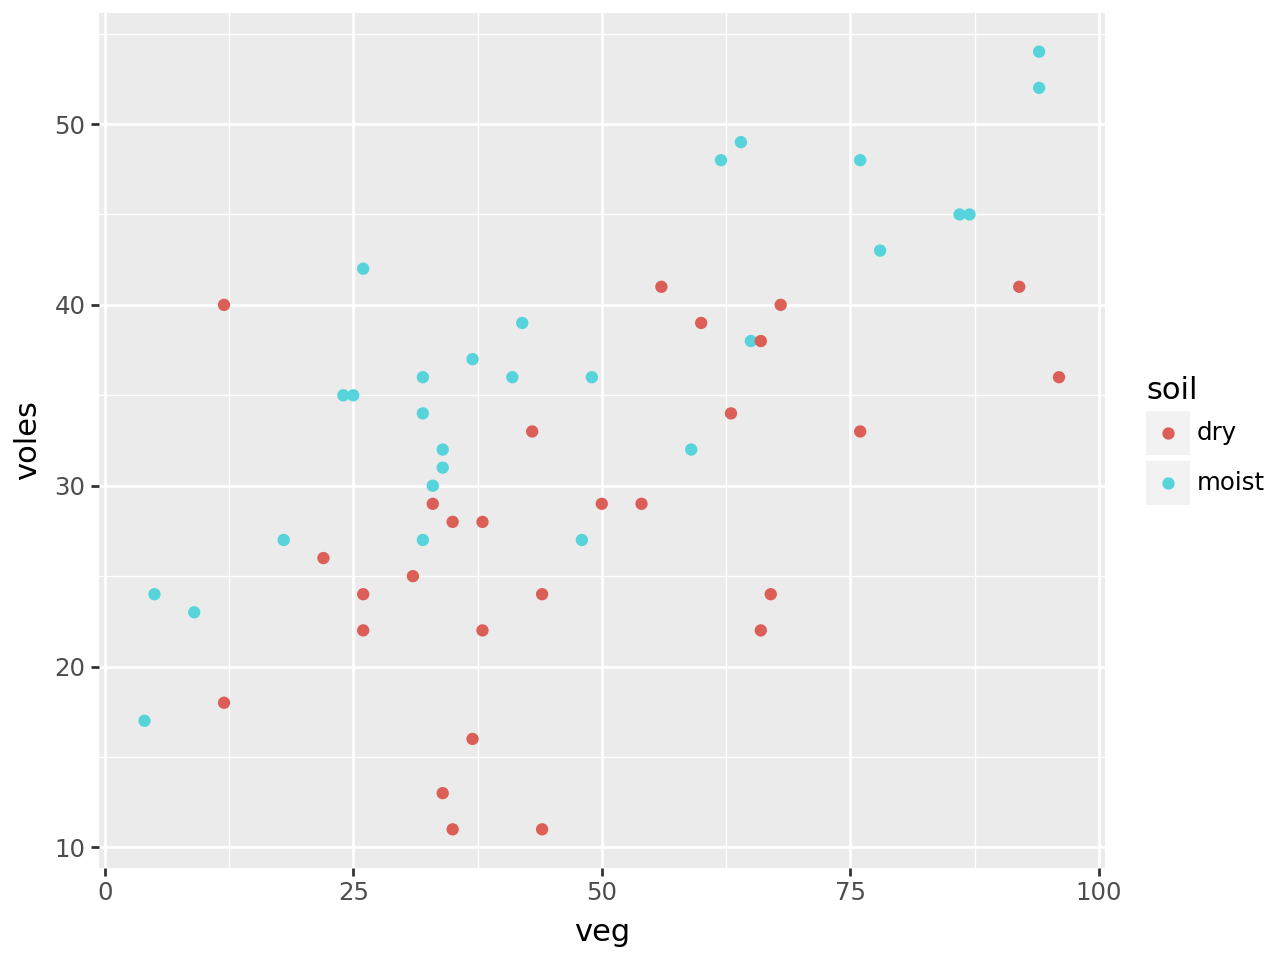

In [4]:
(
    ggplot(df_voles, aes(x = 'veg', y = 'voles', color = 'soil')) + 
    geom_point()
)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [5]:
ct = make_column_transformer(
    ['passthrough', ['veg']],
    [OneHotEncoder(drop='first'), ['soil']]
)

X = df_voles[['site', 'veg', 'soil']]
y = df_voles['voles']

ct.fit_transform(X)

pl = make_pipeline(ct, LinearRegression())

pl.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['veg']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [6]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    
    data = dict(
        term=terms, 
        estimate=estimates
    )
    return pd.DataFrame(data)

In [7]:
get_regression_table(pl)

,term,estimate
0,passthrough__veg,0.259069
1,onehotencoder__soil_moist,9.100298
2,intercept,15.464026


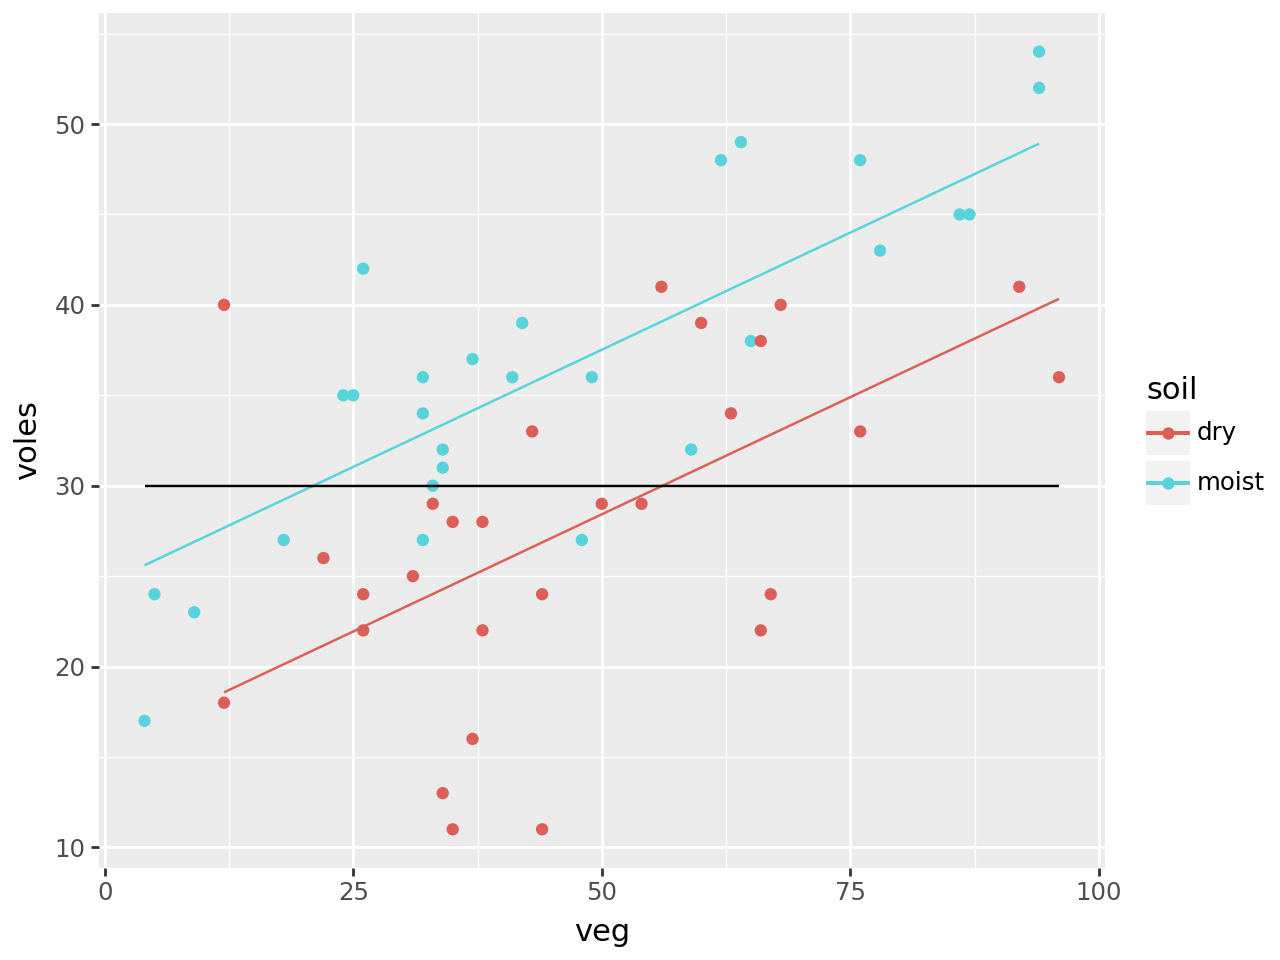

In [9]:
# Predictions
df_voles_preds = df_voles.assign(pred_voles=lambda df_: pl.predict(df_))

# Remaking scatter plot with predictions
(
    ggplot(df_voles_preds, aes(x = 'veg', y = 'voles', color = 'soil')) + 
    geom_point() +
    geom_line(aes(y = 'pred_voles')) +
    geom_line(aes(y = 30), color = 'black')
)

❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

Looking at the chart above, areas with a greater precentange of vegetation cover have higher counts of voles, compared to that of lower vegetation cover. Therefore, protecting a site with high vegetation cover would likely be a more effective way to preserve the vole population than a site with low vegetation cover because higher vegetation cover is associated with an increase in vole numbers. In addition, vegetation cover (passthrough__veg) has a positive estimate of 0.259, meaning that as vegetation cover increases, vole population is expected to increase as well. This suggests that sites with higher vegetation cover are more favorable for vole populations.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

They need to mantain roughly 56% cover of vegetation on these dry sites to support a population of about 30 voles at the site.

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with your pipeline.)

**Answer:**

In [10]:
pl.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

array([34.92708151])

The site might be able to support a vole population of about 35 voles.